In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import torch
import numpy as np
import slim
import matplotlib.pyplot as plt
import seaborn as sns
from neuromancer import blocks, estimators, dynamics, integrators
from neuromancer.activations import activations
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import get_sequence_dataloaders
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
import neuromancer.simulator as sim
from neuromancer.loggers import BasicLogger
from sklearn.preprocessing import MinMaxScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [2]:
def Interp_1D(tq,t,u):

    return u

interp_u = Interp_1D

In [3]:
df_data = pd.read_csv(r"C:\Users\14506\Documents\Doc_Poly\Python\NeuroMancer\RC_Vallianos\house_data.csv")
df_data['Time'] = np.array([x for x in range(0,df_data.shape[0])])
display(df_data.head())

,Time,T01_TEMP,T02_TEMP,T03_TEMP,T04_TEMP,T05_TEMP,T06_TEMP,T07_TEMP,T08_TEMP,T09_TEMP,...,T01_Wh,T02_Wh,T03_Wh,T04_Wh,T05_Wh,T06_Wh,T07_Wh,T08_Wh,T09_Wh,GHI
0,0,17.786,18.351,19.061,19.091,19.214,18.784,19.581,19.188,19.963,...,0.0,1.0,1.0,4.0,6.0,2.0,2.0,2.0,2.0,0.0
1,1,17.394,17.925,18.571,18.596,18.803,17.706,19.052,18.727,19.381,...,82.0,2.0,2.0,4.0,7.0,2.0,2.0,2.0,2.0,0.0
2,2,17.389,17.613,18.063,18.095,18.339,17.974,18.444,18.237,18.902,...,415.0,35.0,2.0,4.0,7.0,2.0,2.0,2.0,2.0,0.0
3,3,17.540,17.567,17.588,17.642,17.915,16.647,17.877,17.759,18.408,...,497.0,123.0,2.0,42.0,7.0,2.0,2.0,25.0,2.0,0.0
4,4,17.667,17.603,17.278,17.337,17.573,17.612,17.376,17.482,18.001,...,432.0,304.0,2.0,206.0,6.0,92.0,157.0,178.0,2.0,0.0


In [4]:
u_array = np.column_stack((
                           df_data['T01_Wh'],
                           df_data['T02_Wh'],
                           df_data['T03_Wh'],
                           df_data['T04_Wh'],
                           df_data['T05_Wh'],
                           df_data['T06_Wh'],
                           df_data['T07_Wh'],
                           df_data['T08_Wh'],
                           df_data['T09_Wh'],
                           df_data['GHI'],
                           df_data['Text']
                           ))

u_scaler = MinMaxScaler(feature_range=(0, 1))
u_scaler.fit(u_array[:-145]) #145 for the 6 days of validation and testing
scaled_u_array = u_scaler.transform(u_array)

y_array = np.column_stack((df_data['T01_TEMP'],
                           df_data['T02_TEMP'],
                           df_data['T03_TEMP'],
                           df_data['T04_TEMP'],
                           df_data['T05_TEMP'],
                           df_data['T06_TEMP'],
                           df_data['T07_TEMP'],
                           df_data['T08_TEMP'],
                           df_data['T09_TEMP'],
                           ))

y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler.fit(y_array[:-145]) #145 for the 6 days of validation and testing
scaled_y_array = y_scaler.transform(y_array)


time_array = np.column_stack((df_data['Time']))


raw = {}
raw['Y'] = scaled_y_array
raw['U'] = scaled_u_array

raw['Y'] = np.reshape(raw['Y'], (-1, scaled_y_array.shape[1]))
raw['U'] = np.reshape(raw['U'], (-1, scaled_u_array.shape[1]))

In [5]:
#  Train, Development, Test sets - nstep and loop format
nsteps = 24 # nsteps rollouts in training
# The split ratio here defines Train, validation and test datasets
nstep_data, loop_data, dims = get_sequence_dataloaders(raw, nsteps,
                            moving_horizon=True, split_ratio = [62.5,12.5],) #batch_size not used here 
train_data, dev_data, test_data = nstep_data
train_loop, dev_loop, test_loop = loop_data

nx = dims['Y'][1]
estim = estimators.FullyObservable(
    {**train_data.dataset.dims, "x0": (nx,)},
    linear_map=slim.maps['identity'],
    input_keys=["Yp"],
)
estim(train_data.dataset.get_full_batch())

{'x0_fully_observable': tensor([[0.1444, 0.2645, 0.3255,  ..., 0.5283, 0.3055, 0.4047],
         [0.0415, 0.1519, 0.2446,  ..., 0.4094, 0.2275, 0.3103],
         [0.0402, 0.0695, 0.1608,  ..., 0.2726, 0.1446, 0.2326],
         ...,
         [0.8939, 0.8859, 0.5503,  ..., 0.7202, 0.5849, 0.6389],
         [0.4769, 0.5400, 0.4862,  ..., 0.6401, 0.5156, 0.5748],
         [0.3251, 0.3847, 0.4347,  ..., 0.5623, 0.4400, 0.5086]]),
 'reg_error_fully_observable': tensor(0.)}

In [6]:
# Instantiate the blocks, dynamics model in Neuromancer:
nx = dims['Y'][1]
nu = dims['U'][1]

black_box_ode = blocks.MLP(insize=nx+nu, outsize=nx, hsizes=[24,24],
                           linear_map=slim.maps['linear'],bias=True,
                           nonlin=activations['softsign'])
    
fx_int = integrators.RK4(black_box_ode, interp_u=interp_u, h=0.2)


fy = slim.maps['identity'](nx, nx)

dynamics_model = dynamics.ODENonAuto(fx_int, fy, extra_inputs=['Uf'],
                input_key_map={"x0": estim.output_keys[0],
                               },
                name='dynamics', online_flag=False)

# Loss:
yhat = variable(dynamics_model.output_keys[2])
y = variable("Yf")

Q_ref = 10.
reference_loss = Q_ref*((yhat == y)^2)
reference_loss.name = "Tracking_loss"

objectives = [reference_loss]

constraints = []
components = [estim, dynamics_model]

# Create optimization loss
loss = PenaltyLoss(objectives, constraints)


# Construct optimization problem
problem = Problem(components, loss)
problem = problem.to(device)


In [7]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.03)

logger = BasicLogger(args=None, savedir='Logger', verbosity=1,
                     stdout=['nstep_dev_loss', 'nstep_train_loss'])
trainer = Trainer(
    problem,
    train_data,
    dev_data,
    test_data,
    optimizer,
    patience=200,
    warmup=500,
    epochs=2000,
    eval_metric="nstep_dev_loss",
    train_metric="nstep_train_loss",
    dev_metric="nstep_dev_loss",
    test_metric="nstep_test_loss",
    device=device,
    logger=logger)

None
Number of parameters: 1329


In [8]:
#Training loop

best_model = trainer.train()
best_outputs = trainer.test(best_model)
print('Best dev loss '+ str(trainer.best_devloss))
problem.load_state_dict(best_model)

epoch: 0	nstep_train_loss: 2.14694	nstep_dev_loss: 1.80856	eltime:  7.11894
epoch: 1	nstep_train_loss: 2.11553	nstep_dev_loss: 1.10112	eltime:  7.36289
epoch: 2	nstep_train_loss: 1.29027	nstep_dev_loss: 1.04654	eltime:  7.61041
epoch: 3	nstep_train_loss: 1.20535	nstep_dev_loss: 1.00317	eltime:  7.86197
epoch: 4	nstep_train_loss: 1.08058	nstep_dev_loss: 0.94226	eltime:  8.09258
epoch: 5	nstep_train_loss: 0.94088	nstep_dev_loss: 0.90379	eltime:  8.32622
epoch: 6	nstep_train_loss: 0.86319	nstep_dev_loss: 0.73463	eltime:  8.53748
epoch: 7	nstep_train_loss: 0.74588	nstep_dev_loss: 0.56836	eltime:  8.79047
epoch: 8	nstep_train_loss: 0.66525	nstep_dev_loss: 0.48185	eltime:  9.03715
epoch: 9	nstep_train_loss: 0.59586	nstep_dev_loss: 0.47512	eltime:  9.27451
epoch: 10	nstep_train_loss: 0.54181	nstep_dev_loss: 0.49339	eltime:  9.53707
epoch: 11	nstep_train_loss: 0.50079	nstep_dev_loss: 0.49994	eltime:  9.76446
epoch: 12	nstep_train_loss: 0.47038	nstep_dev_loss: 0.49801	eltime:  9.98708
epoch: 13

<All keys matched successfully>

In [9]:
# temp_Text = raw['U'][:,-1] 
# temp_U = raw['U'][1:,:]
# temp_U[:,-1] = temp_Text[:-1]
# temp_y = scaled_y_array[:-1,:]


# temp_U = np.insert(temp_U, -1, raw['U'][-1,:], axis=0)
# temp_y = np.insert(temp_y, -1, scaled_y_array[-1,:], axis=0)

In [10]:
"""
Test open loop performance
"""

temp_Text = raw['U'][:,-1] 
temp_U = raw['U'][1:,:]
temp_U[:,-1] = temp_Text[:-1]
temp_y = scaled_y_array[:-1,:]


temp_U = np.insert(temp_U, -1, raw['U'][-1,:], axis=0)
temp_y = np.insert(temp_y, -1, scaled_y_array[-1,:], axis=0)

raw_xn = []
pred_xn = []



for i in range(0,int(len(time_array.T))-1):
    # print(f'Iteration {i}')
    nm_system = sim.DynamicsNeuromancer(dynamics_model.to('cpu'),
                    name='nm', input_key_map={'x': 'x_nm', 'u': 'U'})

    components = [nm_system]
    system_sim = sim.SystemSimulator(components)
    sim_steps = nsteps
    # print(len(time_array.T)-i)
    pad = 0
    if len(time_array.T)-i < sim_steps+1:
        sim_steps = len(time_array.T)-i-1
        pad = 24 - sim_steps
        # print(f'Pad: {pad}')
        # print(f'Sim Steps: {sim_steps}')

    T0 = temp_y[i,:]
    x0 = np.array(T0)


    data_init = {'x_nm': x0}

    U = temp_U[i:i+sim_steps+1, :]
    
    data_traj = {'U': U}
    trajectories = system_sim.simulate(nsim=sim_steps, data_init=data_init,
                                       data_traj=data_traj)
    temp_raw = np.empty((pad,9))
    temp_raw[:] = np.nan
    temp_raw = np.append(raw['Y'][i:i+sim_steps, :],temp_raw)
    temp_raw = temp_raw.reshape(24,9)

    temp_pred = np.empty((pad,9))
    temp_pred[:] = np.nan
    temp_pred = np.append(trajectories['x_nm'][:-1],temp_pred)
    temp_pred = temp_pred.reshape(24,9)


    raw_xn.append(temp_raw)
    pred_xn.append(temp_pred)

In [11]:
raw_xn = np.vstack(raw_xn)
pred_xn = np.vstack(pred_xn)

raw_xn = y_scaler.inverse_transform(raw_xn)
pred_xn = y_scaler.inverse_transform(pred_xn)

In [12]:
xn_df = pd.DataFrame()

for i in range(1,raw['Y'].shape[1]+1):  
    xn_df[f'T_{i}_Real'] = raw_xn[:,i-1]
    xn_df[f'T_{i}_NODE'] = pred_xn[:,i-1]


measured_Real = xn_df.iloc[::24].copy().reset_index(drop=True)


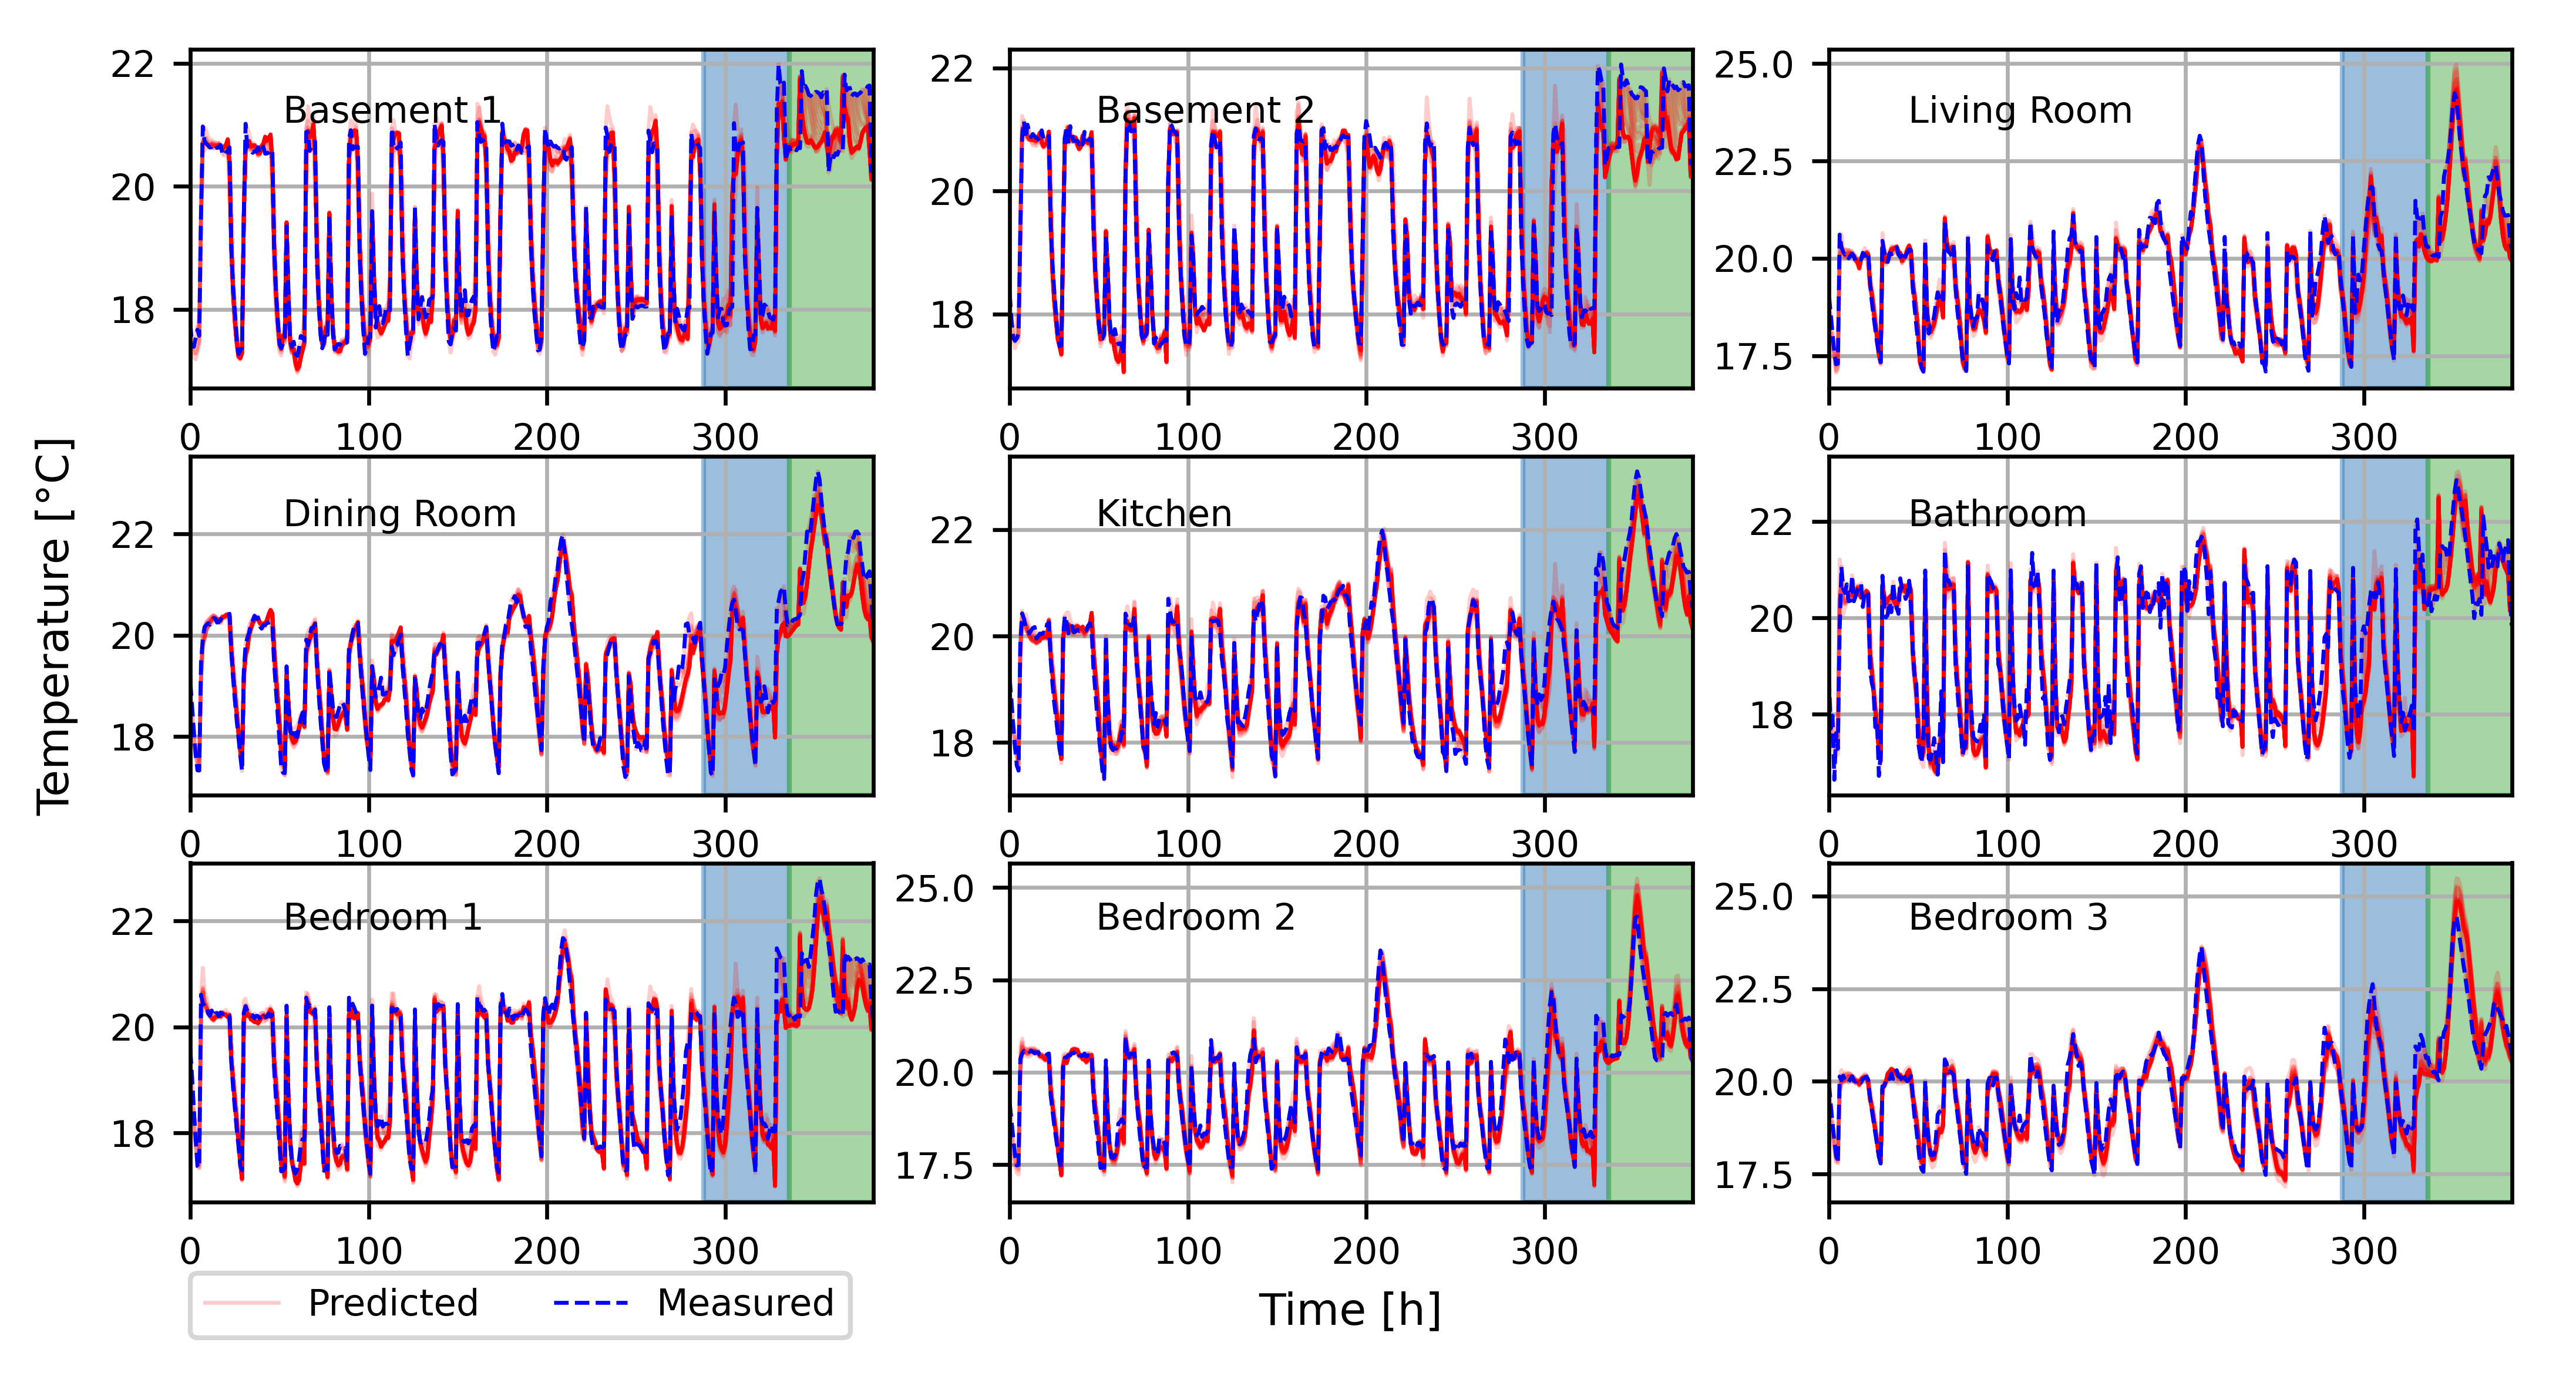

In [13]:
measured_Real = xn_df.iloc[::24].copy().reset_index(drop=True)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

BIGGER_SIZE = 7.5
BIGGEST_SIZE = 9

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGEST_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

fig = plt.figure(figsize=(8.5,8.5/2))
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(331)
ax2 = fig.add_subplot(332)
ax3 = fig.add_subplot(333)
ax4 = fig.add_subplot(334)
ax5 = fig.add_subplot(335)
ax6 = fig.add_subplot(336)
ax7 = fig.add_subplot(337)
ax8 = fig.add_subplot(338)
ax9 = fig.add_subplot(339)


ax_dict = {'ax1' : ax1,
           'ax2' : ax2,
           'ax3' : ax3,
           'ax4' : ax4,
           'ax5' : ax5,
           'ax6' : ax6,
           'ax7' : ax7,
           'ax8' : ax8,
           'ax9' : ax9,
            }

names_arr = ['Basement 1', 'Basement 2', 'Living Room', 'Dining Room', 'Kitchen', 'Bathroom', 'Bedroom 1', 'Bedroom 2', 'Bedroom 3']
names_pos_arr = [[0.05,0.95], [0.05,0.95], 'Living Room', 'Dining Room', 'Kitchen', 'Bathroom', 'Bedroom 1', 'Bedroom 2', 'Bedroom 3']

ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_xlabel('Time [h]')
ax.set_ylabel('Temperature [°C]')

for i in range(1,10):
    
    for j in range(0,len(measured_Real)):
        if j+i == 1:
            ax_dict[f'ax{i}'].plot(range(j,j+24),xn_df[f'T_{i}_NODE'][j*24:(j+1)*24],color='red',alpha=0.2,label=f'Predicted',linewidth=.8)
        else:
            ax_dict[f'ax{i}'].plot(range(j,j+24),xn_df[f'T_{i}_NODE'][j*24:(j+1)*24],color='red',alpha=0.2,linewidth=.8)
    ax_dict[f'ax{i}'].plot(measured_Real[f'T_{i}_Real'],'--',color='blue',label=f'Measured',linewidth=.8)

    
    ax_dict[f'ax{i}'].grid()
    ax_dict[f'ax{i}'].set_xlim(0,383)
    ax_dict[f'ax{i}'].text(0.04+0.35*((i-1)%3), 0.96-0.35*((i-1)//3), names_arr[i-1], transform=ax.transAxes, fontsize=BIGGER_SIZE, verticalalignment='top',)
    ax_dict[f'ax{i}'].axvspan(288,336,color='#377eb8',alpha=0.5)
    ax_dict[f'ax{i}'].axvspan(336,385,color='#4daf4a',alpha=0.5)

    if i == 1:    
        ax_dict[f'ax{i}'].legend(ncols=2,loc=[0,0],bbox_to_anchor=[0,-2.8])
    # ax_dict[f'ax{i}'].legend(loc='best')




# xn_df['T_1_NODE'].plot()

In [14]:
train_valid_error_df = pd.DataFrame()
for i in range(1,10):
    train_valid_error_df[f'T_{i}'] = xn_df[f'T_{i}_NODE'][:6636] - xn_df[f'T_{i}_Real'][:6636]
train_valid_error_df = train_valid_error_df.dropna()
labels = ['Basement 1', 'Basement 2', 'Living Room', 'Dining Room', 'Kitchen', 'Bathroom', 'Bedroom 1', 'Bedroom 2', 'Bedroom 3']
train_valid_error_df.columns = labels
print(f'TV: {len(train_valid_error_df)}')

test1_error_df = pd.DataFrame()
for i in range(1,10):
    test1_error_df[f'T_{i}'] = xn_df[f'T_{i}_NODE'][6636:7788] - xn_df[f'T_{i}_Real'][6636:7788]
test1_error_df = test1_error_df.dropna()
labels = ['Basement 1', 'Basement 2', 'Living Room', 'Dining Room', 'Kitchen', 'Bathroom', 'Bedroom 1', 'Bedroom 2', 'Bedroom 3']
test1_error_df.columns = labels
print(f'T1: {len(test1_error_df)}')

test2_error_df = pd.DataFrame()
for i in range(1,10):
    test2_error_df[f'T_{i}'] = xn_df[f'T_{i}_NODE'][7788:] - xn_df[f'T_{i}_Real'][7788:]
test2_error_df = test2_error_df.dropna()
labels = ['Basement 1', 'Basement 2', 'Living Room', 'Dining Room', 'Kitchen', 'Bathroom', 'Bedroom 1', 'Bedroom 2', 'Bedroom 3']
test2_error_df.columns = labels
print(f'T2: {len(test2_error_df)}')

rank = []
for i in range(0,len(train_valid_error_df)):
    rank.append('Training/Validation')

train_valid_error_df['Rank'] = rank

rank = []
for i in range(0,len(test1_error_df)):
    rank.append('Testing 1')

test1_error_df['Rank'] = rank


rank = []
for i in range(0,len(test2_error_df)):
    rank.append('Testing 2')

test2_error_df['Rank'] = rank

error_df = pd.concat([train_valid_error_df,test1_error_df,test2_error_df])
error_df_long = pd.melt(error_df, id_vars='Rank', value_vars=['Basement 1', 'Basement 2', 'Living Room', 'Dining Room', 'Kitchen', 'Bathroom', 'Bedroom 1', 'Bedroom 2', 'Bedroom 3'])
error_df_long.columns = ['Dataset', 'Zone', 'Error [°C]']
error_df_long

TV: 6636
T1: 1152
T2: 1152


,Dataset,Zone,Error [°C]
0,Training/Validation,Basement 1,0.000000
1,Training/Validation,Basement 1,-0.012049
2,Training/Validation,Basement 1,-0.106110
3,Training/Validation,Basement 1,-0.263314
4,Training/Validation,Basement 1,-0.290645
...,...,...,...
80455,Testing 2,Bedroom 3,-0.063292
80456,Testing 2,Bedroom 3,-0.070962
80457,Testing 2,Bedroom 3,0.000000
80458,Testing 2,Bedroom 3,0.079955


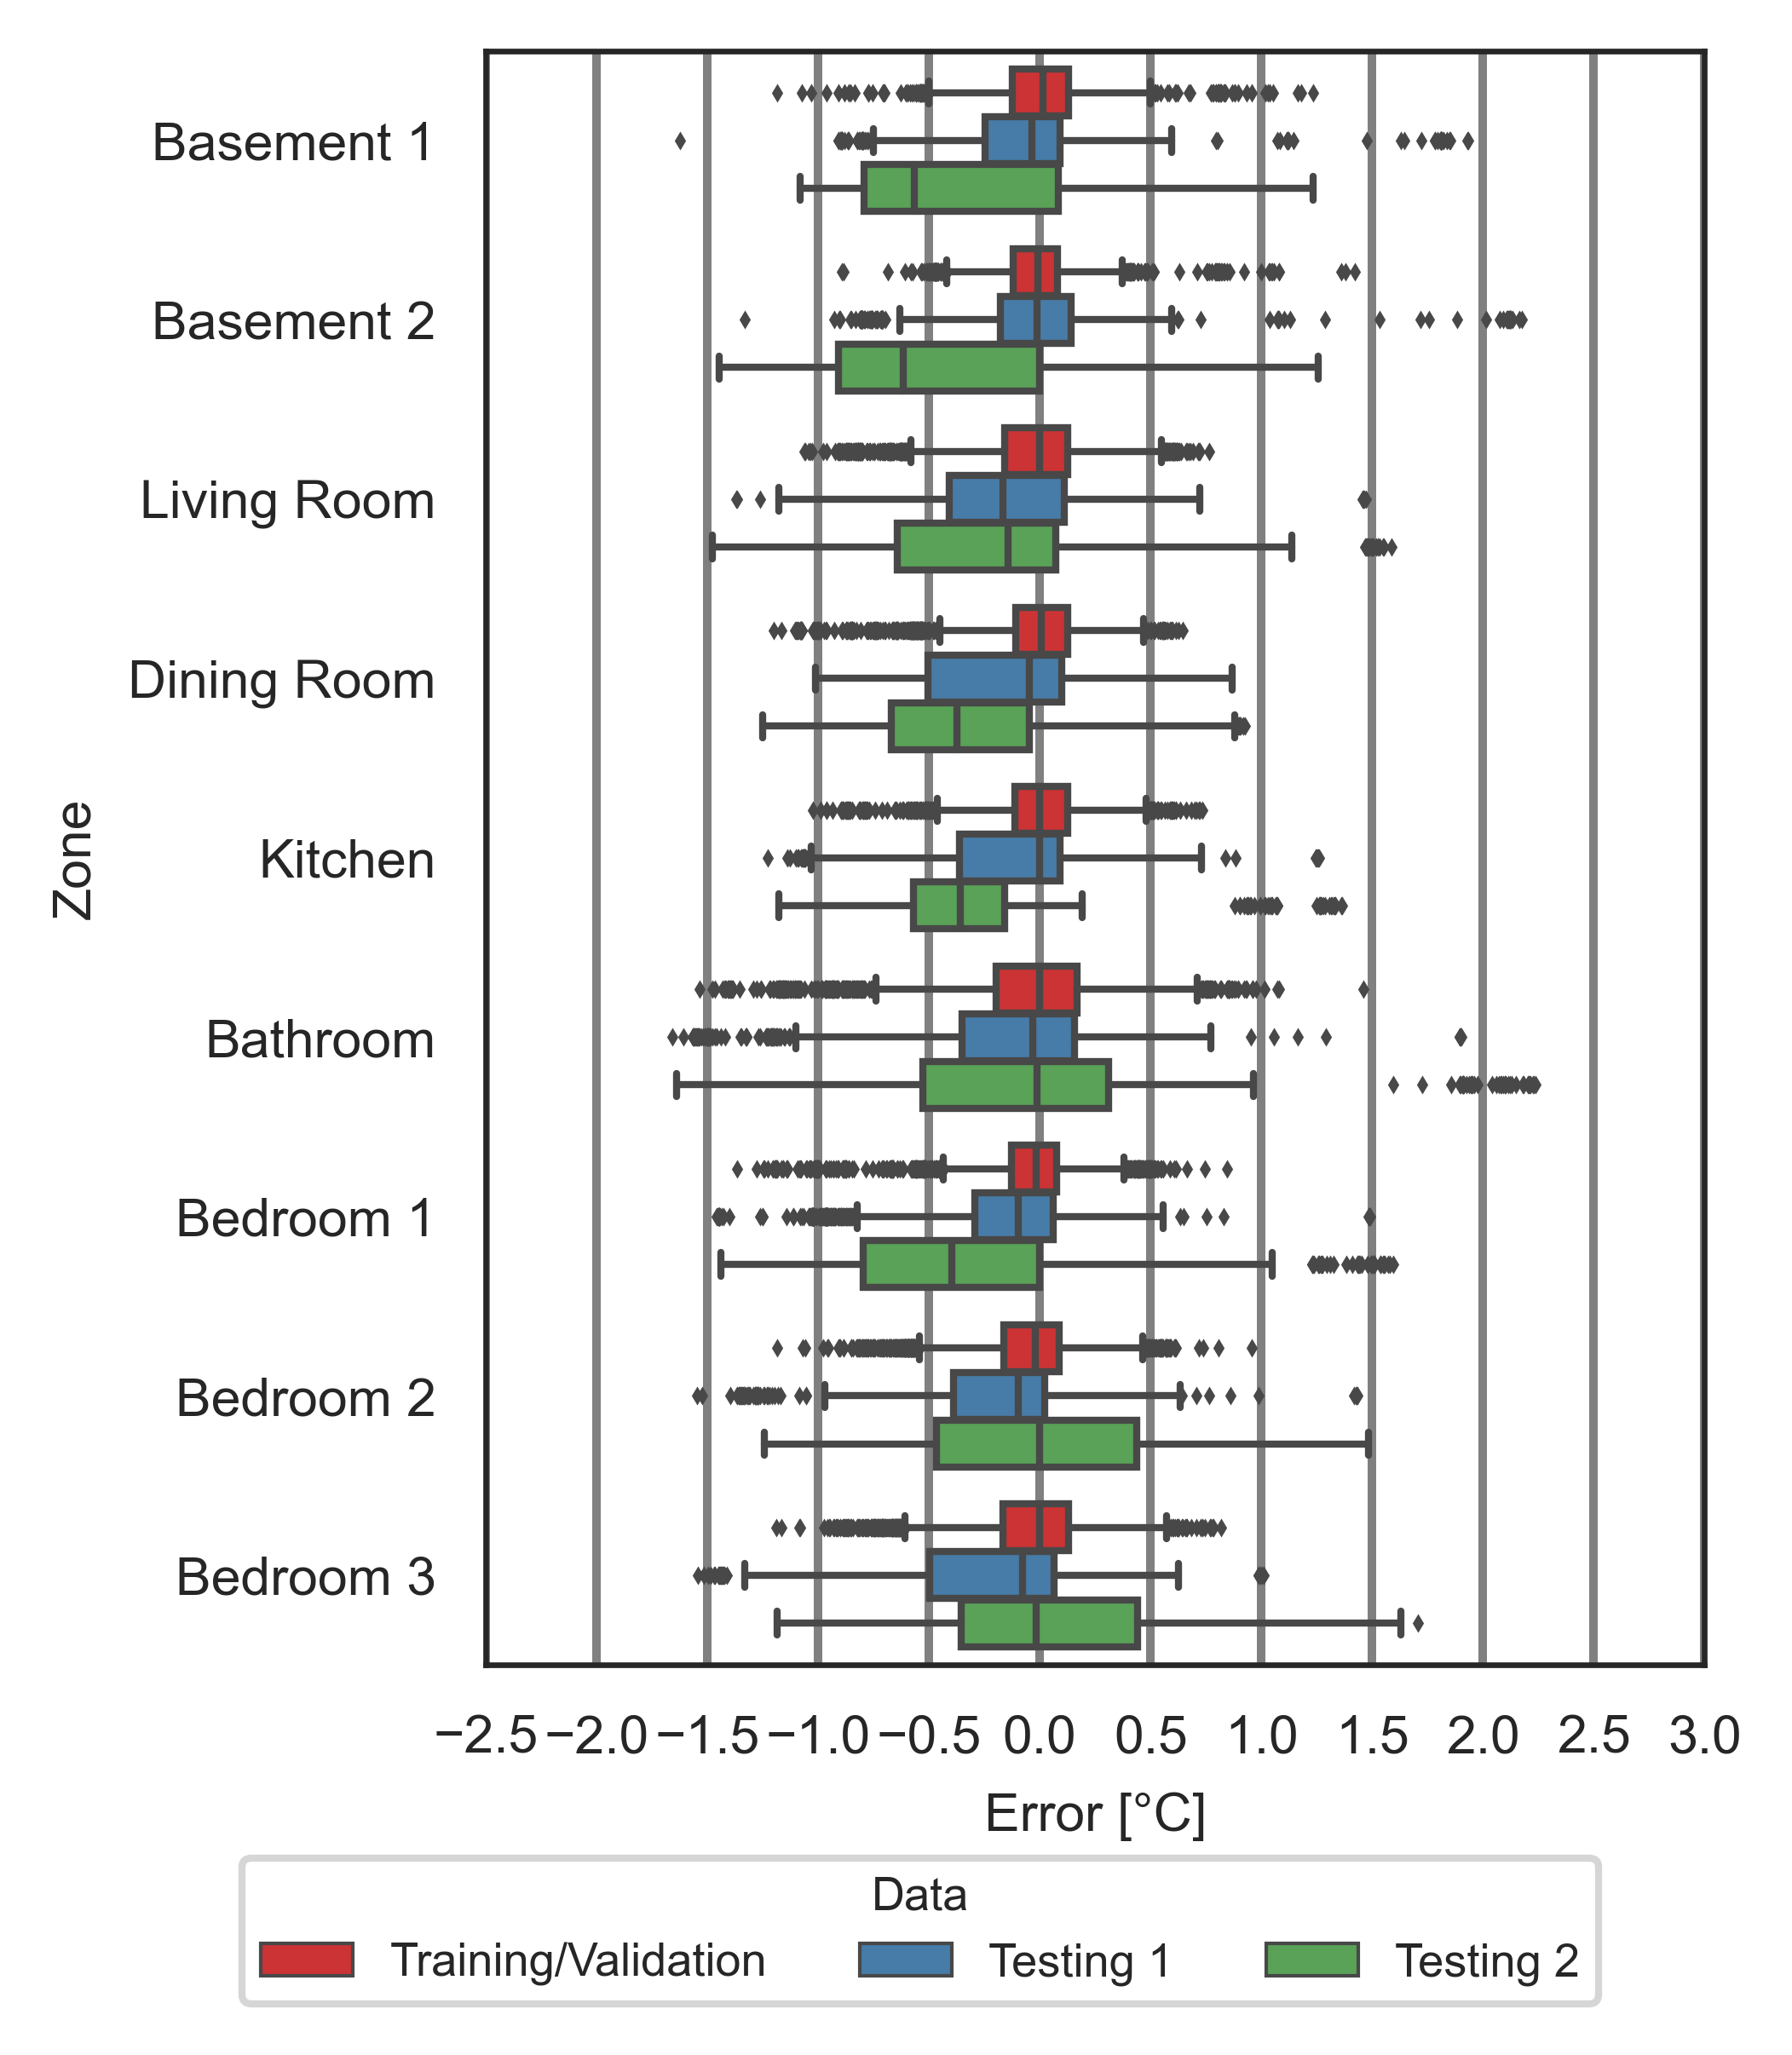

In [15]:
sns.set_style("white")
sns.set_palette('Set1')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
mpl.rcParams['figure.figsize'] = 8.5*8.16/17.59*0.78,8.5*8.16/17.59*8/6*0.78
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3.21, 8/6*3.21))
fig, ax = plt.subplots(nrows=1, ncols=1)

# BIGGER_SIZE = 6
# BIGGEST_SIZE = 7

plt.rc('font', size=BIGGER_SIZE-1)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE-1.5)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE-1)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE-1)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

bplot = sns.boxplot(y="Zone",
            x="Error [°C]",
            hue="Dataset",
            data=error_df_long,
            palette="Set1",
            fliersize=0.5,
            ax=ax,
            linewidth=1.,

            )
bplot.set_xlabel("Error [°C]",fontsize=BIGGER_SIZE)
bplot.set_ylabel("Zone",fontsize=BIGGER_SIZE)

plt.xticks(np.arange(-2.5, 3.5, step=0.5))
ax.grid(b=True, which='major', axis='x', color='gray', linewidth=1.2)
# plt.legend(ncols=1, title='Data',loc=[0.7,0.55])
plt.legend(ncols=3, title='Data',loc=[-0.2,-0.21])




plt.show()